<a href="https://colab.research.google.com/github/gomyk/NNStudy/blob/moonwon/%5BRL%5D%5BQN%5D%5BMW%5D%20Acrobot-v1%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
import gym
from gym.wrappers import Monitor
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import base64

from IPython.display import HTML

from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

from google.colab import output

display = Display(visible=0, size=(400,600),)
display.start()
env = gym.make("Acrobot-v1")

#env = gym.wrappers.Monitor(gym.make("CartPole-v1"), "video", force=True, video_callable=lambda c:c%100 ==0)

# GPU를 사용할 경우
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """transition 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [0]:
HIDDEN_SIZE = 32
class DQN_custom(nn.Module):

    def __init__(self, obs_size, outputs):
        super(DQN_custom, self).__init__()
        self.linear = nn.Linear(obs_size, HIDDEN_SIZE)
        self.linear2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.linear3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.head = nn.Linear(HIDDEN_SIZE, outputs)
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = F.relu(self.linear2(x))
        #x = F.relu(self.linear3(x))
        return self.head(x)

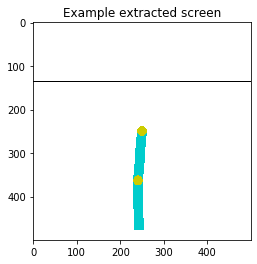

In [5]:
env.reset()
plt.figure()
plt.imshow(env.render(mode='rgb_array'))
plt.title('Example extracted screen')
plt.show()

In [0]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000
TARGET_UPDATE = 10
LR = 0.01
MEMORY_SIZE = 10000
EPISODE_SIZE = 2000

# gym 행동 공간에서 행동의 숫자를 얻습니다.
n_actions = env.action_space.n
n_obvs = 6

policy_net = DQN_custom(n_obvs, n_actions).to(device)
policy_net.eval()
target_net = DQN_custom(n_obvs, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(MEMORY_SIZE)


steps_done = 0

def select_action(obs):
    global steps_done
    sample = random.random()
    steps_done += 1
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            obs = torch.FloatTensor(obs).to(device)
            output = policy_net(obs).cpu()
            predicted = np.argmax(output.data.numpy())
            return torch.tensor([[predicted]],device=device, dtype=torch.long)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

In [0]:
def select_action_target(obs):
      with torch.no_grad():
         obs = torch.FloatTensor(obs).to(device)
         output = target_net(obs).cpu()
         predicted = np.argmax(output.data.numpy())
         return torch.tensor([[predicted]],device=device, dtype=torch.long)

In [0]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return -1
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). 이것은 batch-array의 Transitions을 Transition의 batch-arrays로
    # 전환합니다.
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state).to(device)
    reward_batch = torch.cat(batch.reward).to(device)
    action_batch = torch.cat(batch.action).to(device)
 
    non_final_mask = map(lambda s: s is not None, batch.next_state)
    non_final_mask = tuple(non_final_mask)
    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.BoolTensor(non_final_mask)

    # We don't want to backprop through the expected action values and volatile
    # will save us on temporarily changing the model parameters'
    # requires_grad to False!
    non_final_next_states = [s.view(1, -1) for s in batch.next_state if s is not None]
    non_final_next_states = torch.cat(non_final_next_states, 0).to(device)
  

    # Q(s_t, a) 계산 - 모델이 Q(s_t)를 계산하고, 취한 행동의 열을 선택합니다.
    # 이들은 policy_net에 따라 각 배치 상태에 대해 선택된 행동입니다.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 모든 다음 상태를 위한 V(s_{t+1}) 계산
    # non_final_next_states의 행동들에 대한 기대값은 "이전" target_net을 기반으로 계산됩니다.
    # max(1)[0]으로 최고의 보상을 선택하십시오.
    # 이것은 마스크를 기반으로 병합되어 기대 상태 값을 갖거나 상태가 최종인 경우 0을 갖습니다.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Huber 손실 계산
    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    #for param in policy_net.parameters():
    #    param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.cpu().data.numpy()

0 episode , 500 step , -0.25 Loss, 0.71 Threshold , -1.00 Top reward
1 episode , 500 step , 0.01 Loss, 0.57 Threshold , -1.00 Top reward
2 episode , 500 step , 0.00 Loss, 0.45 Threshold , -1.00 Top reward
3 episode , 500 step , 0.00 Loss, 0.36 Threshold , -1.00 Top reward
4 episode , 500 step , 0.00 Loss, 0.29 Threshold , -1.00 Top reward
5 episode , 500 step , 0.00 Loss, 0.24 Threshold , -1.00 Top reward
6 episode , 500 step , 0.00 Loss, 0.20 Threshold , -1.00 Top reward
7 episode , 500 step , 0.00 Loss, 0.17 Threshold , -1.00 Top reward
8 episode , 500 step , 0.00 Loss, 0.14 Threshold , -1.00 Top reward
9 episode , 500 step , 0.00 Loss, 0.12 Threshold , -1.00 Top reward
10 episode , 500 step , 0.00 Loss, 0.10 Threshold , -1.00 Top reward
11 episode , 500 step , 0.02 Loss, 0.09 Threshold , -1.00 Top reward
12 episode , 500 step , 0.01 Loss, 0.08 Threshold , -1.00 Top reward
13 episode , 500 step , 0.01 Loss, 0.08 Threshold , -1.00 Top reward
14 episode , 500 step , 0.01 Loss, 0.07 Thr

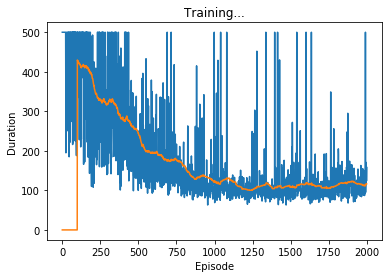

In [9]:
num_episodes = EPISODE_SIZE
for i_episode in range(num_episodes):
    # 환경과 상태 초기화
    obv = env.reset()
    total_loss = 0
    global steps_done
    top_reward = -1
    for t in count():
        # 행동 선택과 수행
        action = select_action(obv)
        next_obv, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        if not done:
          next_state = torch.FloatTensor([next_obv])
        else:
          next_state = None
        # 메모리에 변이 저장
        assert obv is not None
        memory.push(torch.FloatTensor([obv]), action, next_state, reward)

        # 다음 상태로 이동
        obv = next_obv

        # 최적화 한단계 수행(목표 네트워크에서)
        total_loss += optimize_model()
        if done:
            E = eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
            episode_durations.append(t + 1)
            print('%d episode , %d step , %.2f Loss, %.2f Threshold , %.2f Top reward'%(i_episode,t+1,total_loss/(t+1),E, top_reward))
            plot_durations()
            total_loss = 0
            top_reward = 0
            break
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.show()